# 1. Import libraries

In [9]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import os

from xml.etree import ElementTree

from tqdm.auto import tqdm

from PIL import Image
from IPython.display import display

import cv2

from matplotlib import pyplot as plt
import matplotlib.patches as patches

# 2. Read dataset

## 2.1. Read raw images

In [11]:
DATA_PATH = "../data/dataset/"

In [17]:
# read files from data dir
data_files = os.listdir(DATA_PATH)

# collect pathes of .bmap and .xml files
img_files = sorted([img for img in data_files if img[-4:] == ".bmp" and img[0] != "."])
xml_files = sorted([img for img in data_files if img[-4:] == ".xml" and img[0] != "."])

len(img_files), len(xml_files)

(8325, 8325)

## 2.2. Extract bounding boxes

In [19]:
# Extract bbox coordinates
def extract_boxes(xml_path, class_mapping):

    tree = ElementTree.parse(xml_path)
    root = tree.getroot()
    image_name = root.find("filename").text
    
    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
        
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
    
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    shape = [width, height]
    
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    
    return image_name, boxes, shape, class_ids

In [20]:
# Only stenosis object to detect -> in real problem 2 classes: higher and upper part of coronary vessel
class_ids = ["Stenosis"]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [21]:
xml_paths, img_paths = [], []
shapes, bboxes, classes = [], [], []

for xml_file in tqdm(xml_files):
    xml_path = os.path.join(DATA_PATH, xml_file)
    image_name, boxes, shape, class_id = extract_boxes(xml_path, class_mapping)
    if len(class_id) > 1:
        continue
    img_path = os.path.join(DATA_PATH, image_name)
    bboxes.append(boxes)
    shapes.append(shape)
    classes.append(class_id)
    xml_paths.append(xml_path)
    img_paths.append(img_path)

100%|██████████| 8325/8325 [00:45<00:00, 184.94it/s]


## 2.3. Borders removal

In [28]:
iterator_imgs = iter(img_paths)
iterator_bbox = iter(bboxes)

In [29]:
img_path = next(iterator_imgs)
img_bbox = next(iterator_bbox)
img = cv2.imread(img_path)

In [36]:
x, y, dx, dy = img_bbox[0]
width, height = dx - x, dy - y

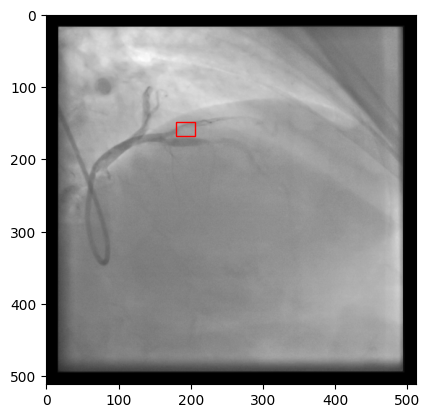

In [37]:
fig, ax = plt.subplots()
ax.imshow(img)
rect = patches.Rectangle((x,y), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [69]:
cropped_img, nx, ny, ndy, ndx = crop_border(img, border_threshold=30, black_pixels_threshold=0.3)

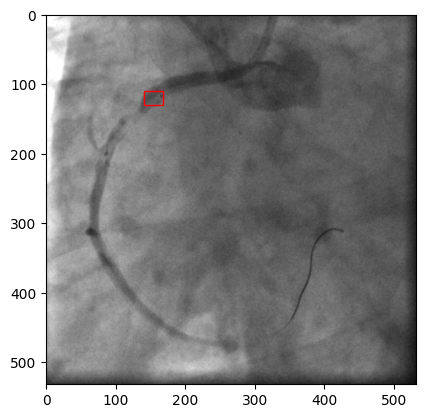

In [70]:
fig, ax = plt.subplots()
ax.imshow(cropped_img)
rect = patches.Rectangle((x-nx, y-ny), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [68]:
def crop_border(img, border_threshold=30, black_pixels_threshold=0.4, square_size=True, max_border=0.2):
    """
    img: cv2 image
    border_threshold: max pixel value to be interpreted as background
    black_pixels_threshold: fraction of all pixels that must be assumed 
        to be background to classify a whole row as background.
    """
    height, width, channels = img.shape

    max_border *= height
    
    top_border_height = 0
    bottom_border_height = 0
    left_border_width = 0
    right_border_width = 0
    
    # iterating over top
    for i in range(int(height/2)):
        pixels_top_half = img[i, :, 0]
        black_pixels_sum = np.sum(pixels_top_half < border_threshold)
        if black_pixels_sum > width * black_pixels_threshold:
            top_border_height+=1
        else:
            break
    
    # iterating over bottom
    for i in range(height-1, int(height/2)-1, -1):
        pixels_bottom_half = img[i, :, 0]
        black_pixels_sum = np.sum(pixels_bottom_half < border_threshold)
        if black_pixels_sum > width * black_pixels_threshold:
            bottom_border_height+=1
        else:
            break
    
    # iterating over left side
    for i in range(int(width/2)):
        pixels_left_half = img[:, i, 0]
        black_pixels_sum = np.sum(pixels_left_half < border_threshold)
        if black_pixels_sum > width * black_pixels_threshold:
            left_border_width+=1
        else:
            break
    
    # iterating over right side
    for i in range(width-1, int(width/2)-1, -1):
        pixels_right_half = img[:, i, 0]
        black_pixels_sum = np.sum(pixels_right_half < border_threshold)
        if black_pixels_sum > width * black_pixels_threshold:
            right_border_width+=1
        else:
            break
            
    if square_size:
        max_1 = max(left_border_width, right_border_width)
        max_2 = max(bottom_border_height, top_border_height)
        max_3 = max(max_1, max_2)
        max_3 = max(max_3, max_border)
        top_border_height = max_3
        bottom_border_height = max_3
        right_border_width = max_3
        left_border_width = max_3

    nx = left_border_width
    ny = top_border_height
    w = width - right_border_width
    h = height - bottom_border_height
    ndy = ny + h
    ndx = nx + w
    
    return img[ny:h, nx:w, :], nx, ny, ndx, ndy

In [71]:
def normalize_brighteness(img, default_brighteness=128):
    avg_brightness = img[:, :, 0].sum() / (img.shape[0] * img.shape[1])
    x = default_brighteness / avg_brightness
    new_img = img[:, :, :] * x
    new_img = new_img.astype('uint8')
    new_img = ((new_img - new_img.min()) * (1/(new_img.max() - new_img.min()) * 255)).astype('uint8')
    return new_img

In [72]:
def preprocess_img_bbox(img_path, bbox, img_target_size=512):
    img = cv2.imread(img_path)
    bbox_x, bbox_y, bbox_dx, bbox_dy = bbox[0]
    
    img_cropped, nx, ny, nw, nh = crop_border(
        img, border_threshold=40, black_pixels_threshold=0.5
    )
    
    bbox_nx, bbox_ny = bbox_x - nx, bbox_y - ny
    bbox_ndx, bbox_ndy = bbox_dx - nx, bbox_dy - ny

    bb_width = bbox_ndx - bbox_nx
    bb_height = bbox_ndy - bbox_ny
    
    img_height, img_width, _ = img_cropped.shape
    img_height_scale, img_width_scale = img_target_size/img_height, img_target_size/img_width
    
    img_resized = cv2.resize(
        img_cropped, (img_target_size, img_target_size)
    )

    bbox_nx_resized = int(np.round(bbox_nx * img_width_scale))
    bbox_ny_resized = int(np.round(bbox_ny * img_height_scale))
    bbox_ndx_resized = int(np.round(bbox_ndx * img_width_scale))
    bbox_ndy_resized = int(np.round(bbox_ndy * img_height_scale))

    img_resized_norm = normalize_brighteness(img_resized)
    
    return img_resized_norm, [[bbox_nx_resized, bbox_ny_resized, bbox_ndx_resized, bbox_ndy_resized]]

In [73]:
img_target_size = 512

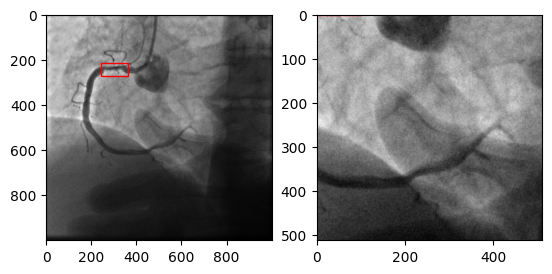

In [79]:
j = 750
img_path = img_paths[j]
bbox = bboxes[j]

img = cv2.imread(img_path)
prep_img, prep_bbox = preprocess_img_bbox(img_path, bbox)

bbox_x, bbox_y, bbox_dx, bbox_dy = bbox[0]
bbox_nx, bbox_ny, bbox_ndx, bbox_ndy = prep_bbox[0]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
rect = patches.Rectangle(
    (bbox_x, bbox_y), bbox_dx - bbox_x, bbox_dy - bbox_y, linewidth=1, edgecolor='r', facecolor='none'
)
ax1.add_patch(rect)

ax2.imshow(prep_img)
rect = patches.Rectangle(
    (bbox_nx, bbox_ny), bbox_ndx - bbox_nx, bbox_ndy - bbox_ny, linewidth=1, edgecolor='r', facecolor='none'
)
ax2.add_patch(rect)
plt.show()

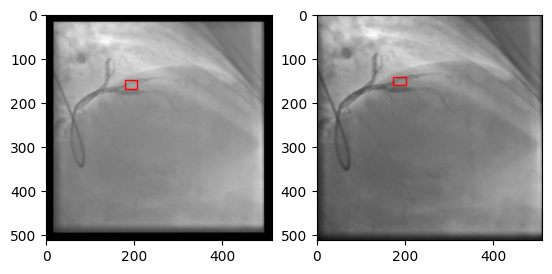

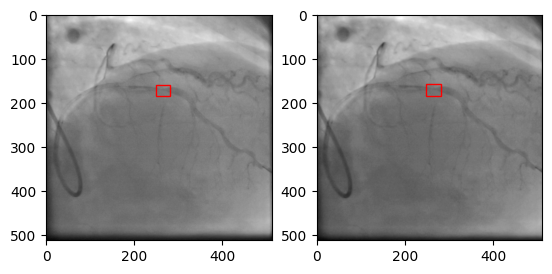

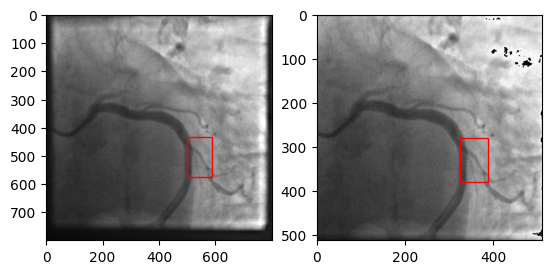

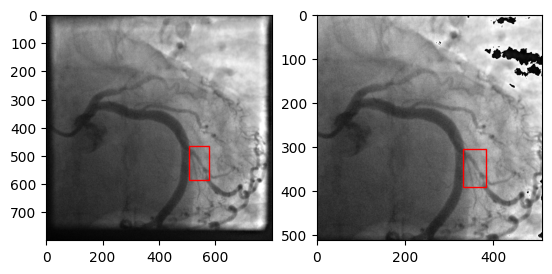

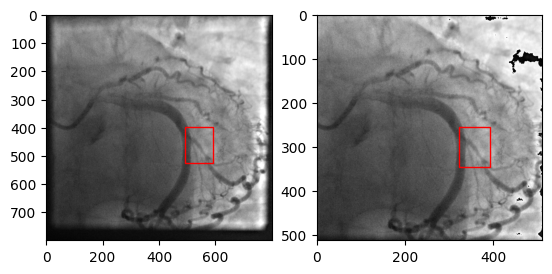

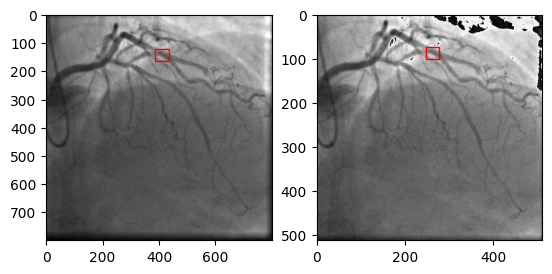

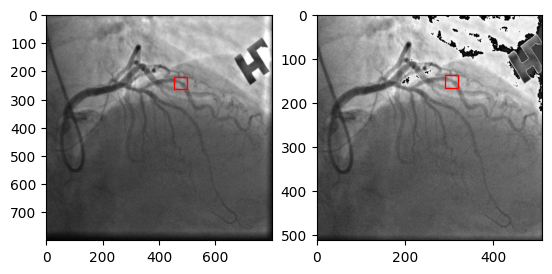

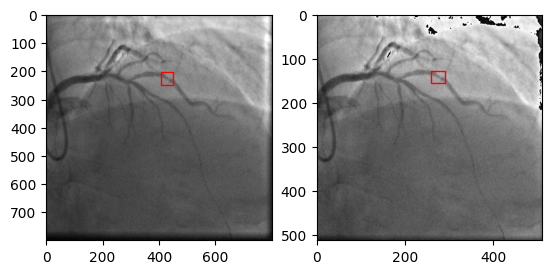

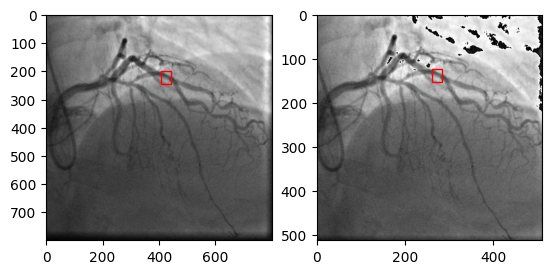

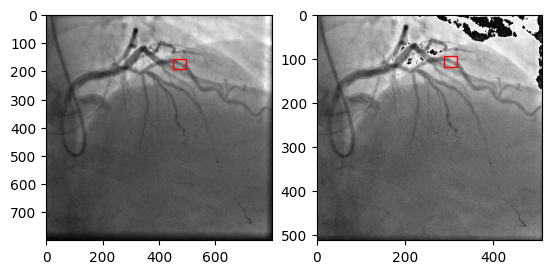

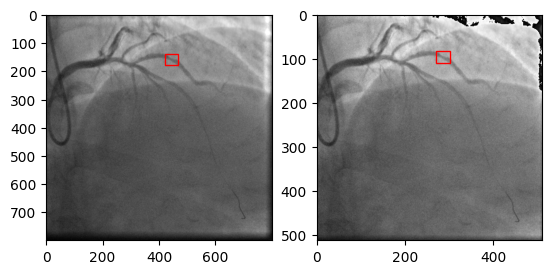

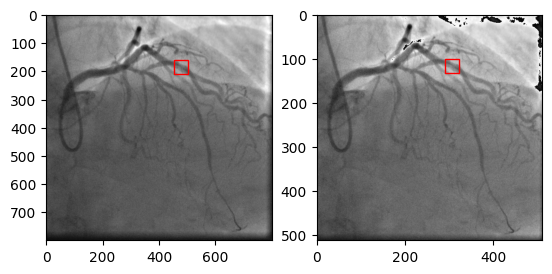

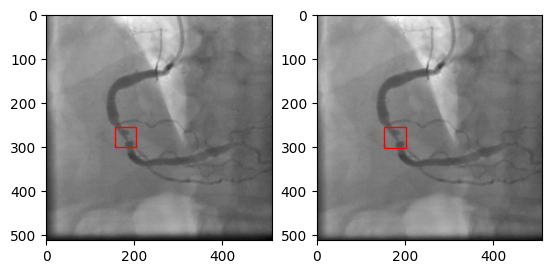

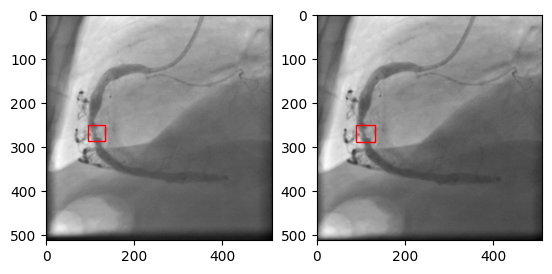

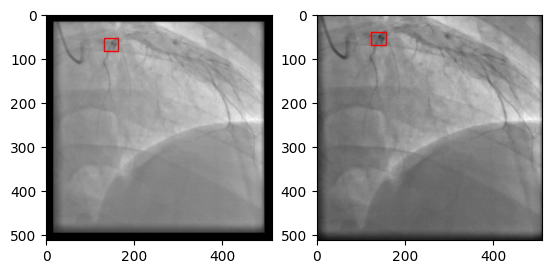

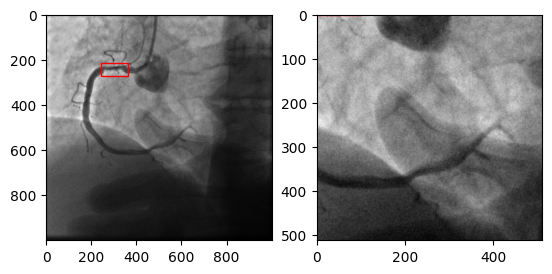

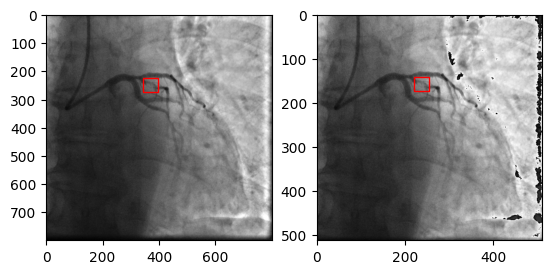

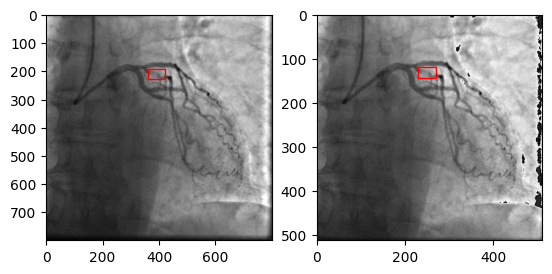

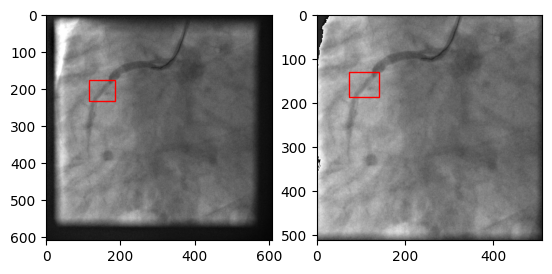

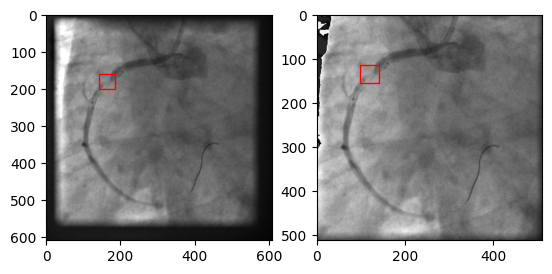

In [74]:
for j in range(0, 1000, 50):
    
    img_path = img_paths[j]
    bbox = bboxes[j]
    
    img = cv2.imread(img_path)
    prep_img, prep_bbox = preprocess_img_bbox(img_path, bbox)
    
    bbox_x, bbox_y, bbox_dx, bbox_dy = bbox[0]
    bbox_nx, bbox_ny, bbox_ndx, bbox_ndy = prep_bbox[0]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    rect = patches.Rectangle(
        (bbox_x, bbox_y), bbox_dx - bbox_x, bbox_dy - bbox_y, linewidth=1, edgecolor='r', facecolor='none'
    )
    ax1.add_patch(rect)
    
    ax2.imshow(prep_img)
    rect = patches.Rectangle(
        (bbox_nx, bbox_ny), bbox_ndx - bbox_nx, bbox_ndy - bbox_ny, linewidth=1, edgecolor='r', facecolor='none'
    )
    ax2.add_patch(rect)
    plt.show()

0 ../data/dataset/14_002_5_0016.bmp


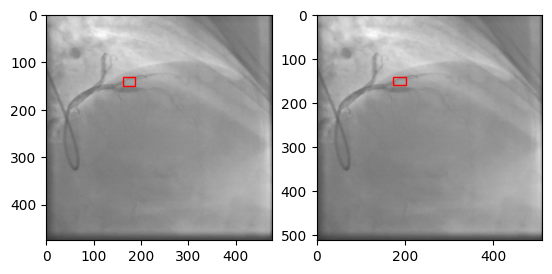

50 ../data/dataset/14_002_8_0026.bmp


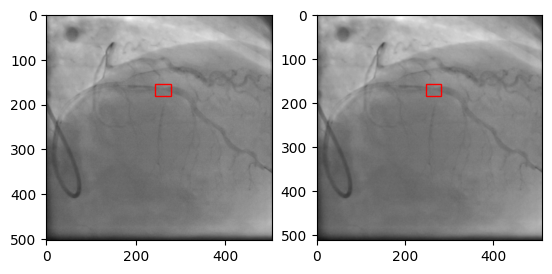

100 ../data/dataset/14_006_1_0044.bmp


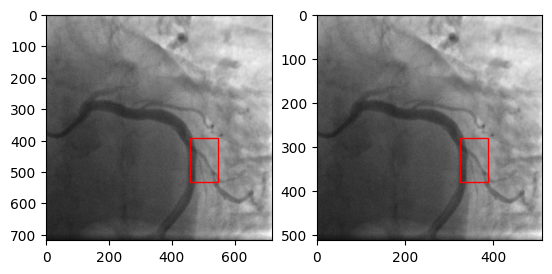

150 ../data/dataset/14_006_1_0094.bmp


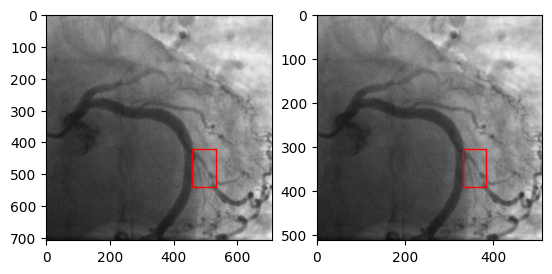

200 ../data/dataset/14_006_1_0144.bmp


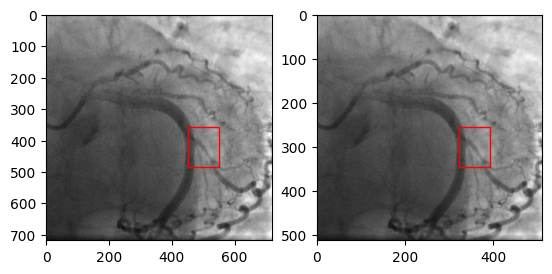

250 ../data/dataset/14_007_10_0076.bmp


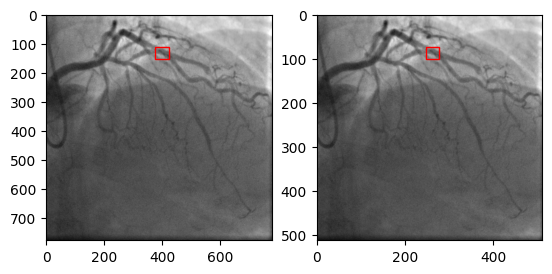

300 ../data/dataset/14_007_3_0057.bmp


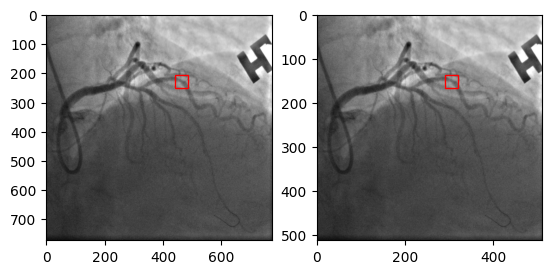

350 ../data/dataset/14_007_5_0049.bmp


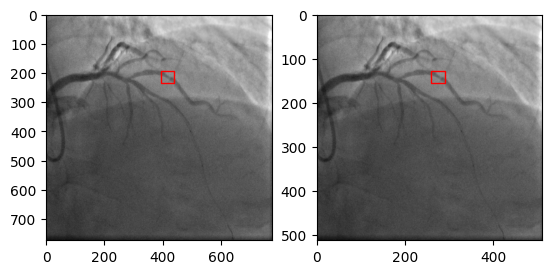

400 ../data/dataset/14_007_5_0099.bmp


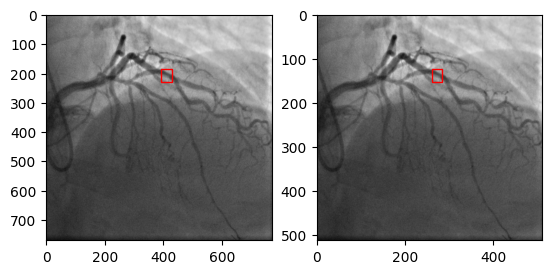

450 ../data/dataset/14_007_6_0052.bmp


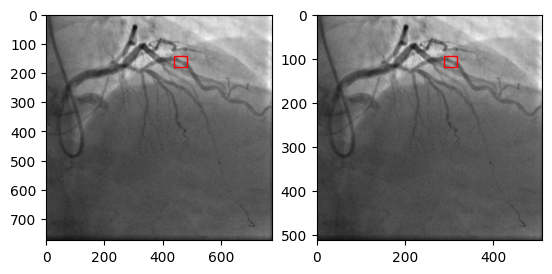

500 ../data/dataset/14_007_8_0038.bmp


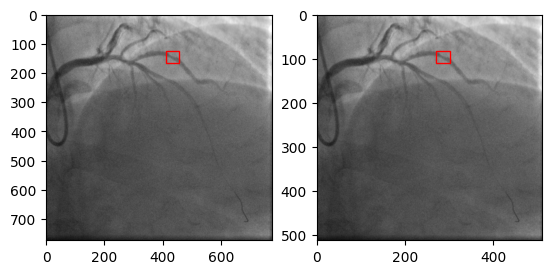

550 ../data/dataset/14_007_8_0088.bmp


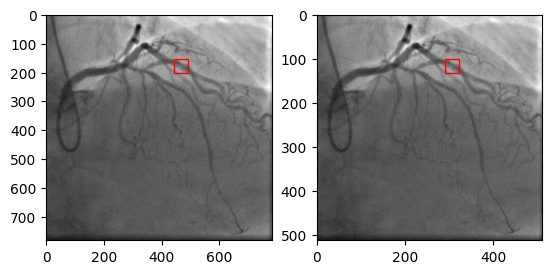

600 ../data/dataset/14_010_1_0025.bmp


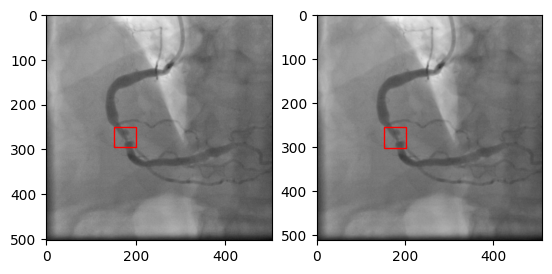

650 ../data/dataset/14_010_6_0034.bmp


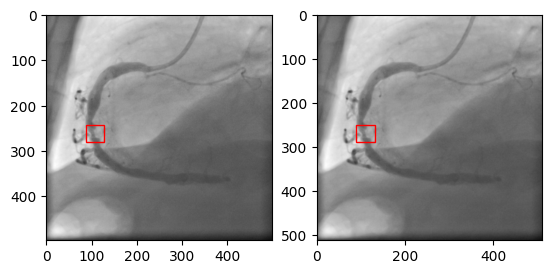

700 ../data/dataset/14_012_4_0036.bmp


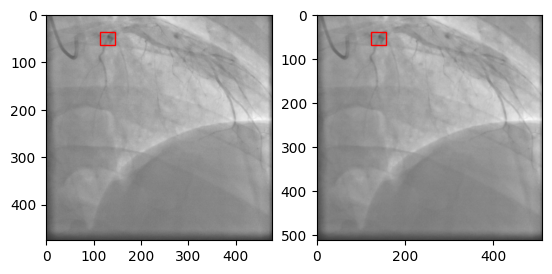

750 ../data/dataset/14_015_1_0027.bmp


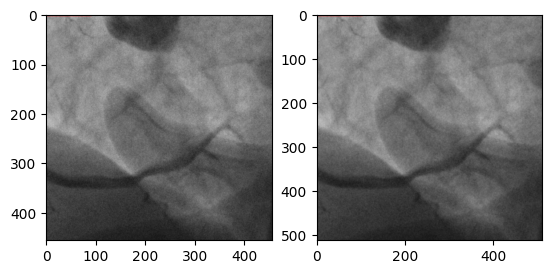

800 ../data/dataset/14_016_1_0013.bmp


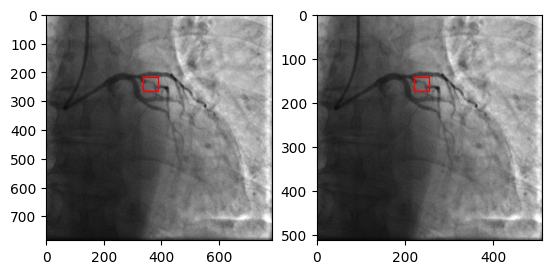

850 ../data/dataset/14_016_1_0063.bmp


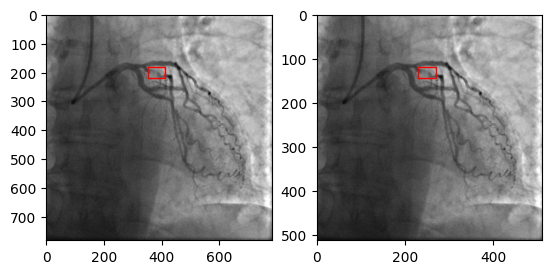

900 ../data/dataset/14_018_6_0020.bmp


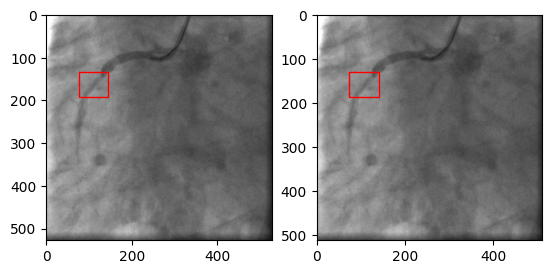

950 ../data/dataset/14_018_8_0027.bmp


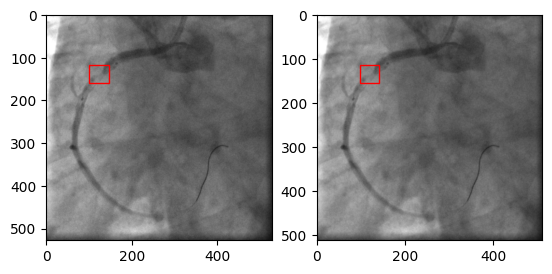

In [77]:
for j in range(0, 1000, 50):
    print(j, img_paths[j])
    img = cv2.imread(img_paths[j])
    bbox_x, bbox_y, bbox_dx, bbox_dy = bboxes[j][0]
    
    img_cropped, nx, ny, ndy, ndx = crop_border(
        img, border_threshold=40, black_pixels_threshold=0.5
    )
    bbox_nx, bbox_ny = bbox_x - nx, bbox_y - ny
    bbox_ndx, bbox_ndy = bbox_dx - nx, bbox_dy - ny

    bb_width = bbox_ndx - bbox_nx
    bb_height = bbox_ndy - bbox_ny
    
    img_height, img_width, _ = img_cropped.shape
    img_height_scale, img_width_scale = img_target_size/img_height, img_target_size/img_width
    
    img_resized = cv2.resize(
        img_cropped, (img_target_size, img_target_size)
    )

    bbox_nx_resized = int(np.round(bbox_nx * img_width_scale))
    bbox_ny_resized = int(np.round(bbox_ny * img_height_scale))
    bbox_ndx_resized = int(np.round(bbox_ndx * img_width_scale))
    bbox_ndy_resized = int(np.round(bbox_ndy * img_height_scale))

    bb_width_resized = bbox_ndx_resized - bbox_nx_resized
    bb_height_resized = bbox_ndy_resized - bbox_ny_resized

    fig, (ax1, ax2) = plt.subplots(1, 2)
    rect = patches.Rectangle(
        (bbox_nx, bbox_ny), bb_width, bb_height, linewidth=1, edgecolor='r', facecolor='none'
    )
    ax1.imshow(img_cropped)
    ax1.add_patch(rect)
    ax2.imshow(img_resized)
    rect = patches.Rectangle(
        (bbox_nx_resized, bbox_ny_resized), bb_width_resized, bb_height_resized, linewidth=1, edgecolor='r', facecolor='none'
    )
    ax2.add_patch(rect)
    plt.show()

In [ ]:
# ++uśrednić jasność

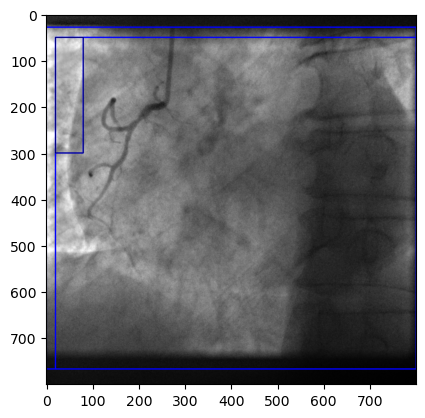

In [66]:
plt.imshow(cv2.rectangle(img, (20, 50), (80, 300), 1))
plt.show()

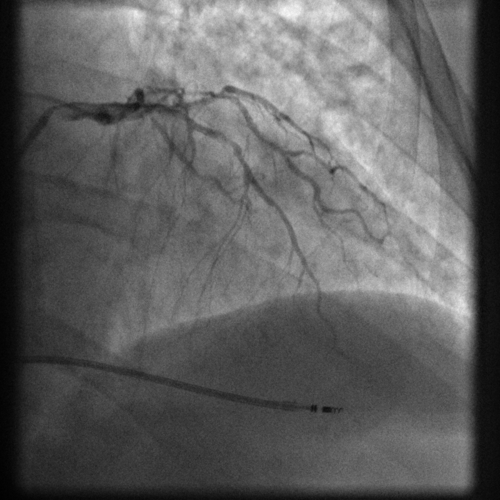

In [5]:
img_path = os.path.join(DATA_PATH, image_files[6328])
display(Image.open(img_path).convert('RGB').resize((500, 500)))

In [7]:
img = cv2.imread(img_path)
height, width, channels = img.shape
height, width, channels

(800, 800, 3)

In [37]:
sum(img[-7] < 20)[0]

270

In [18]:
np.sum(img[0, :, 0] < 10)

11

In [31]:
top_border_height, bottom_border_height, left_border_width, right_border_width

(0, 10, 34, 35)

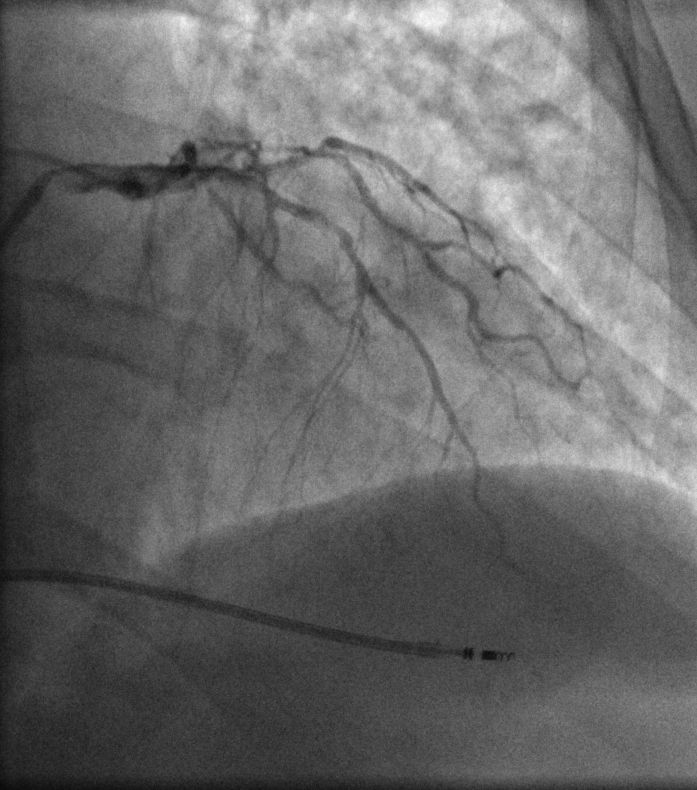

In [12]:
# sanity check - if every .bmp has its corresponding .xml
[[img, xml] for img, xml in zip(image_files, xml_files) if img[:-4] != xml[:-4]]

[]